In [ ]:
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt 
from preprocess import cleaner
import utils

### اینجا اگه اون خطوط کامنت شده رو انکامنت کنی برای طول عرض جغرافیایی که خود این کتابخونه هه نداشته یه مقدار -۱ میذاره ولی اگه اینکارو نکنی 
### null
### میشه

In [2]:
def get_location_coordinates(loc_series, language='en'):
    unique_district = loc_series.astype(str)
    unique_district = unique_district.unique().tolist()
    loc_teh = [s + ' tehran' for s in unique_district]
    loc = []
    lats = []
    longs = []
    geolocator = Nominatim(user_agent="your_app_name")
    for item in loc_teh:
        location = geolocator.geocode(item)
        if location:
            loc.append(item.removesuffix(' tehran'))
            lats.append(location.latitude)
            longs.append(location.longitude)
        # else:
        #     loc.append(item.removesuffix(' tehran'))
        #     lats.append(-1)
        #     longs.append(-1)
    coordinates_df = pd.DataFrame({'loc_name':loc,'lat':lats,'long':longs})
    return coordinates_df

In [3]:
def distance(lat1,lon1,lat2,lon2): 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2)  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))  
    r = 6371
    dist_km = c * r
    return(dist_km) 

In [4]:
def near_metro(coordinates_df,metro_df,min_dist):
    region_len = len(coordinates_df)
    metro_len = len(metro_df)
    region = []
    near_dist = []
    for i in range(region_len):
        for j in range(metro_len):
            dist = distance(coordinates_df.iloc[i,1],coordinates_df.iloc[i,2],metro_df.iloc[j,1],metro_df.iloc[j,2])
            if dist <= min_dist:
                region.append(coordinates_df.iloc[i,0])
                near_dist.append(dist)
                break
    if_near = pd.DataFrame({'region':region})
    coordinates_df['if_near'] = coordinates_df.iloc[:,0].isin(if_near['region']).astype(int)
    return coordinates_df

## Example

In [5]:
metro_df = pd.read_csv('metro.csv')

In [6]:
raw_df = pd.read_csv('Post-2023-11-17.csv')
df = cleaner.Cleaner(raw_df).transform()

/tmp/ipykernel_9025/1867850012.py:1: DtypeWarning: Columns (10,11,12,13,16,17,55,56,58,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('Post-2023-11-17.csv')


In [7]:
coordinates_df = get_location_coordinates(df['district'],language='en')

In [8]:
if_near = near_metro(coordinates_df,metro_df,1)

In [9]:
if_near

,loc_name,lat,long,if_near
0,chitgar,35.716956,51.243865,1
1,shahrak-e-gharb,35.759061,51.376042,1
2,sharif,35.703101,51.352451,1
3,shokoofeh,35.707866,51.370302,0
4,nazi-abad,35.641538,51.402494,0
...,...,...,...,...
229,shahrak-golha,35.702151,51.268309,0
230,malek-abad,36.258615,50.013921,0
231,fath,35.643552,51.315798,0
232,mehrabad-airport,35.688075,51.313628,0


In [10]:
new_data = df.loc[:,['district','price_per_meter']]
new_data

,district,price_per_meter
0,chitgar,11٬000٬000 تومان
1,shahrak-e-gharb,272٬151٬000 تومان
2,darrous,250٬000٬000 تومان
3,chitgar,62٬500٬000 تومان
4,sharif,80٬000٬000 تومان
...,...,...
80722,chitgar,38٬095٬000 تومان
80723,sazamn-barnameh,71٬093٬000 تومان
80724,andisheh,36٬400٬000 تومان
80725,nazi-abad,65٬000٬000 تومان


In [11]:
new_data["price_per_meter"]= new_data["price_per_meter"].apply(lambda x: str(x).replace('تومان',''))
new_data["price_per_meter"] = new_data["price_per_meter"].str.replace('\D', '', regex=True)
new_data["price_per_meter"] = pd.to_numeric(new_data["price_per_meter"])
new_data

,district,price_per_meter
0,chitgar,11000000.0
1,shahrak-e-gharb,272151000.0
2,darrous,250000000.0
3,chitgar,62500000.0
4,sharif,80000000.0
...,...,...
80722,chitgar,38095000.0
80723,sazamn-barnameh,71093000.0
80724,andisheh,36400000.0
80725,nazi-abad,65000000.0


In [12]:
for_visualization = pd.merge(new_data, if_near[['loc_name','long','lat']], left_on='district', right_on='loc_name', how='left')

In [13]:
for_visualization

,district,price_per_meter,loc_name,long,lat
0,chitgar,11000000.0,chitgar,51.243865,35.716956
1,shahrak-e-gharb,272151000.0,shahrak-e-gharb,51.376042,35.759061
2,darrous,250000000.0,NaN,NaN,NaN
3,chitgar,62500000.0,chitgar,51.243865,35.716956
4,sharif,80000000.0,sharif,51.352451,35.703101
...,...,...,...,...,...
80722,chitgar,38095000.0,chitgar,51.243865,35.716956
80723,sazamn-barnameh,71093000.0,NaN,NaN,NaN
80724,andisheh,36400000.0,andisheh,51.262441,35.748503
80725,nazi-abad,65000000.0,nazi-abad,51.402494,35.641538


In [14]:
for_visualization["price_per_meter"]= for_visualization["price_per_meter"].apply(lambda x: str(x).replace('تومان',''))
for_visualization["price_per_meter"] = for_visualization["price_per_meter"].str.replace('\D', '', regex=True)
for_visualization["price_per_meter"] = pd.to_numeric(for_visualization["price_per_meter"])

In [16]:
x = for_visualization.drop(["price_per_meter"], inplace=False, axis=1)
y = for_visualization["price_per_meter"]

In [17]:
from sklearn.model_selection import train_test_split
x_train, _test, y_train, y_test =  train_test_split(x, y, test_size=0.2, random_state=42)
new_x = x_train.copy()

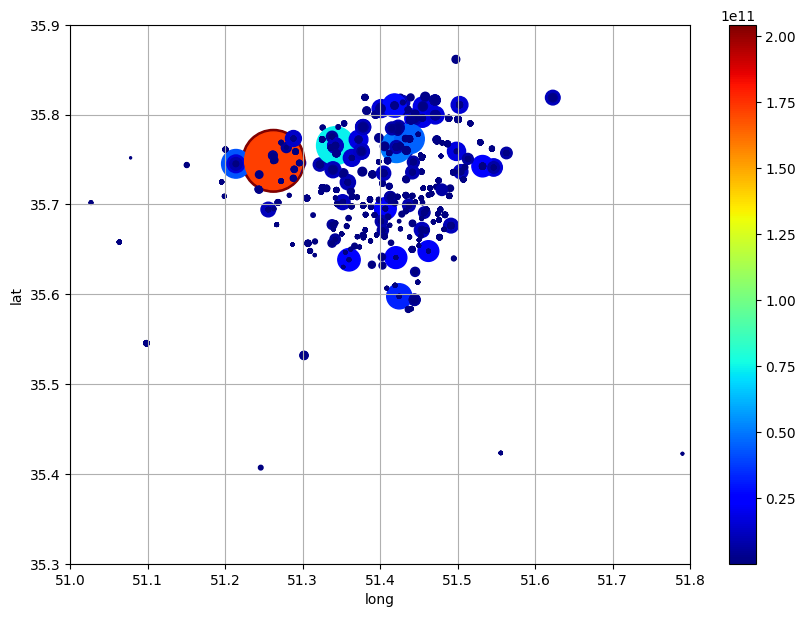

In [18]:
import matplotlib.pyplot as plt
new_x.plot(kind="scatter", x="long", y="lat", grid=True,
             s=y_train/10e7, c=y_train, 
             cmap="jet", colorbar=True, 
             legend=True, sharex=False, figsize=(10, 7))
plt.xlim(51,51.8)
plt.ylim(35.3,35.9)
# plt.xlim(50,53)
# plt.ylim(33,38)
plt.show()

In [8]:
near_metro(coordinates_df,metro_df,1)

,loc_name,lat,long,if_near
0,chitgar,35.716956,51.243865,1
1,shahrak-e-gharb,35.759061,51.376042,1
2,sharif,35.703101,51.352451,1
3,shokoofeh,35.707866,51.370302,0
4,nazi-abad,35.641538,51.402494,0
5,salamat,35.754919,51.452311,0
6,north-shahran,35.773359,51.288250,0
7,pirouzi,35.690905,51.457152,1
8,east-tehranpars,35.741104,51.546615,0
9,heravi,35.772042,51.473187,1


In [9]:
coordinates_df

,loc_name,lat,long,if_near
0,chitgar,35.716956,51.243865,1
1,shahrak-e-gharb,35.759061,51.376042,1
2,sharif,35.703101,51.352451,1
3,shokoofeh,35.707866,51.370302,0
4,nazi-abad,35.641538,51.402494,0
5,salamat,35.754919,51.452311,0
6,north-shahran,35.773359,51.288250,0
7,pirouzi,35.690905,51.457152,1
8,east-tehranpars,35.741104,51.546615,0
9,heravi,35.772042,51.473187,1
